Import the necessary libraries.

In [168]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

European call option.

*   Define the function for the theoretical option price using BSM.
*   Define the function for the simulated option price.
*   Define the function to simulate M prices using n = 1000 stock paths from simulated_call_price

In [169]:
def BSM_call_price(S0, K, T, r, q, v):
  d1 = (np.log(S0/K) + (r - q + v**2 /2)*T) / (v*np.sqrt(T))
  d2 = d1 - v*np.sqrt(T)
  price = S0*np.exp(-q*T)*stats.norm.cdf(d1) - K*np.exp(-r*T)*stats.norm.cdf(d2)
  return price

def simulated_call_price(S0, K, T, r, q, v, n): #n = number of paths simulated
  rng = np.random.default_rng() #set generator PCG64
  z = rng.standard_normal(size=n) #nx1 array of standard normal random variables
  S = S0 * np.exp((r-q-v**2/2)*T + v*np.sqrt(T)*z) #nx1 array of stock price at time T - by simulated paths
  disc_payoffs = np.exp(-r*T) * np.maximum(S-K, 0.0) #nx1 array of discounted payoffs of a European call option
  sim_price = np.mean(disc_payoffs) #take the mean of the n payoffs = simulated price
  return sim_price

def simulation_adjustM(M, S0, K, T, r, q, v, n):
  data = []
  for i in range(M):
    data.append(simulated_call_price(S0, K, T, r, q, v, n))
  plt.hist(data, bins = 100, color='orange')
  plt.xlabel('Simulated Price')
  plt.ylabel('Frequency')
  plt.title('Monte Carlo Simulation - European Call Option')
  plt.axvline(BSM_call_price(S0, K, T, r, q, v), color= 'black', linestyle = 'dashed', linewidth = 2, label = 'BSM theoretical price')
  plt.legend()
  return plt

Set the parameters.  We will adjust M the number of simulated prices and fix n the number of simulated stock paths (which we take the mean of to yield a single simulated price).  The graphs converge towards normal with a mean given by the theoretical option price (which can by found using BSM) by the central limit theorem.

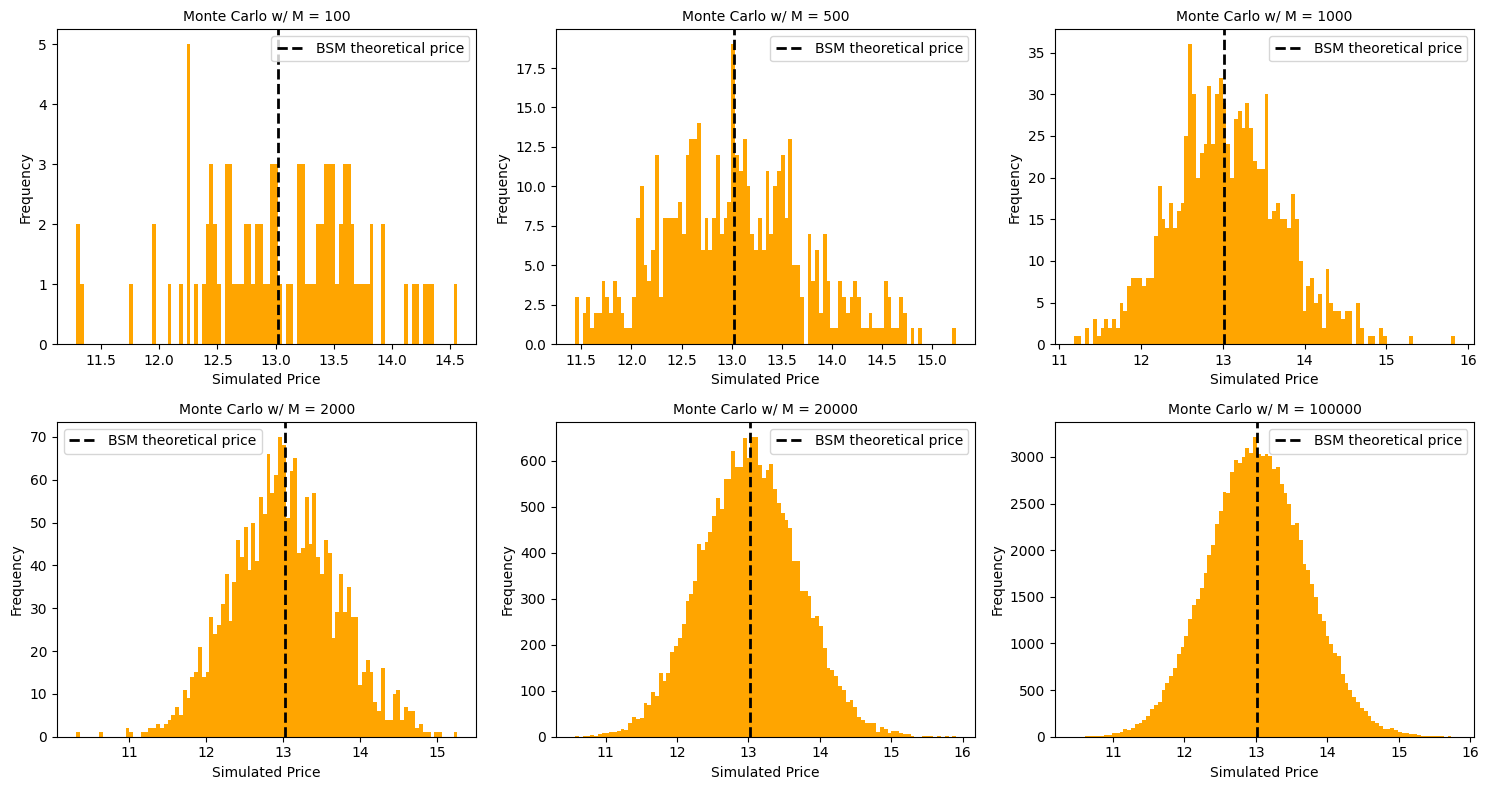

In [170]:
S0, K, T, r, q, v, n = 100,100,1,0.05,0.02,0.30, 1000 #set parameters
M_values = [100, 500, 1000, 2000, 20000, 100000]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, M in enumerate(M_values):
    plt.sca(axes[i])
    simulation_adjustM(M, S0, K, T, r, q, v, n)
    axes[i].set_title(f'Monte Carlo w/ M = {M}', fontsize=10)
plt.tight_layout()
plt.show()

Clearly, using the principle of convergence of the distribution of the simulations towards a normal distribution (by CLT) where the mean is the theoretical option price is ideal.  However, there are certain computational costs as we increase M.  This is evident as pushing M towards just 10^5 forces a rather long runtime.  Therefore, we seek methods to reduce variance in the distribution of the simulations without pushing M towards infinity.  One of these methods is called antithetic sampling.

Why Use Antithetic Sampling?
* Reduces Variance: Antithetic pairs create negative correlation, leading to lower variance in estimates.
* Improves Convergence: Faster convergence in Monte Carlo methods, requiring fewer samples.
* More Stable Estimates: Reduces the risk of overestimating or underestimating results.

In [171]:
def sim_option_price2(S0, K, T, r, q, v, n):
  rng = np.random.default_rng() #set generator PCG64
  z = rng.standard_normal(size=n//2) #nx1 array of standard normal random variables
  Z = np.array(list(z)+list(-z))
  S = S0 * np.exp((r-q-v**2/2)*T + v*np.sqrt(T)*Z) #nx1 array of stock price at time T - by simulated paths
  disc_payoffs = np.exp(-r*T) * np.maximum(S-K, 0.0) #nx1 array of discounted payoffs of a European call option
  sim_price = np.mean(disc_payoffs) #take the mean of the n payoffs = simulated price
  return sim_price

Now, we will generate M = 1000 prices (using the average discounted payoff of n = 10000 stock paths for each price).  Then we will compare the variance of the method above and antithetic sampling.

In [175]:
def sim_option_price2(S0, K, T, r, q, v, n):
    """Antithetic sampling for European call option"""
    rng = np.random.default_rng() #set generator PCG64
    z = rng.standard_normal(size=n) #nx1 array of standard normal random variables
    Z_combined = np.array(list(z)+list(-z))
    S = S0 * np.exp((r-q-v**2/2)*T + v*np.sqrt(T)*Z_combined)
    payoff = np.maximum(S - K, 0)
    disc_payoffs = np.exp(-r * T) * payoff
    sim_price = np.mean(disc_payoffs)
    return sim_price

Variance (Regular): 0.022541
Variance (Antithetic): 0.014011


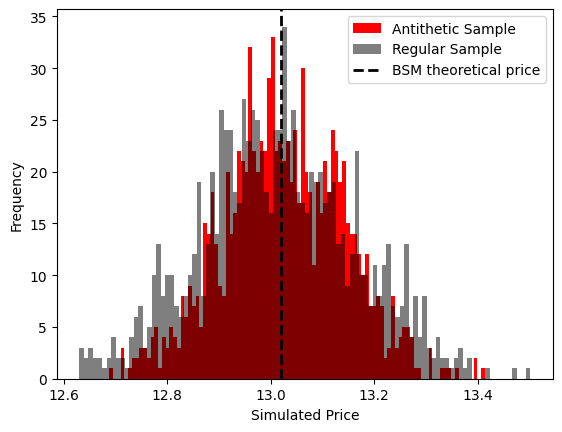

In [183]:
M = 1000  # Number of times to run each simulation

regular_samples = np.array([simulated_call_price(S0 = 100, K = 100, T = 1, r = 0.05, q = 0.02, v = 0.30, n = 20000) for i in range(M)]) #Note C_2n
antithetic_samples = np.array([sim_option_price2(S0 = 100, K = 100, T = 1, r = 0.05, q = 0.02, v = 0.30, n = 10000) for j in range(M)]) #Note C'_n

#Antithetic Sampling provides the following -> Var(C'_n)<=Var(C_2n)

plt.hist(antithetic_samples, bins = 100, alpha = 1, color='red', label = 'Antithetic Sample')
plt.xlabel('Simulated Price')
plt.ylabel('Frequency')
plt.legend()

plt.hist(regular_samples, bins = 100, alpha = 0.5, color='black', label = 'Regular Sample')
plt.xlabel('Simulated Price')
plt.ylabel('Frequency')
plt.axvline(BSM_call_price(S0, K, T, r, q, v), color= 'black', linestyle = 'dashed', linewidth = 2, label = 'BSM theoretical price')
plt.legend()

# Print variances to verify the theoretical result
print(f"Variance (Regular): {np.var(regular_samples):.6f}")
print(f"Variance (Antithetic): {np.var(antithetic_samples):.6f}")

assert np.var(antithetic_samples) <= np.var(regular_samples) , 'Error: variance reduction is incorrect theory is not valid'

Clearly, we have validated through simulation that antithetic sampling provides significant variance reduction and requires less computational power.